In [2]:
# Importer DataGenerator depuis le fichier data_generator.py
from DataGenerator import DataGenerator

In [3]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'  # Configurer segmentation-models pour utiliser tf.keras

## Initialisation des paramètres

In [4]:
# Nombre de classes et poids pour l'entrainement
import pandas as pd

# Chargement du fichier class_weights.csv
class_weights_path = './data/class_weights.csv'
class_weights_df = pd.read_csv(class_weights_path)

# Calcul du nombre de classes (en-tête non inclus)
num_classes = len(class_weights_df)  # Nombre de lignes sans l'en-tête

# Création de la variable class_weights (colonne 'train_class_weights')
class_weights = class_weights_df['train_class_weights'].tolist()

In [5]:
class_weights_df

,CLASSES,train_class_weights
0,void,0.047312
1,flat,0.012541
2,construction,0.022235
3,object,0.275403
4,nature,0.032225
5,sky,0.137174
6,human,0.406959
7,vehicle,0.066151


In [6]:
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 0.0473117178270692,
 1: 0.0125407958691378,
 2: 0.0222351597861851,
 3: 0.2754032980979569,
 4: 0.0322249748165913,
 5: 0.137173815082615,
 6: 0.4069592459275001,
 7: 0.0661509925929445}

In [7]:
class_names = class_weights_df["CLASSES"].tolist()
class_names

['void', 'flat', 'construction', 'object', 'nature', 'sky', 'human', 'vehicle']

In [8]:
# Paramètres de taille des images
img_dim = 128  # Dimension des images (les images seront carrées)
image_size = (img_dim, img_dim)  # Taille des images
input_shape = (*image_size, 3)  # Forme d'entrée des images (hauteur, largeur, canaux)

In [9]:
# Initialisation des hyperparamètres par défaut
learning_rate = 1e-4
batch_size = 16

## Données

In [10]:
# Chargement des chemins des données
import numpy as np

# Chargement des chemins des images et masques pour validation
val_input_img_paths = np.load('data/val_input_img_paths.npy')
val_label_ids_img_paths = np.load('data/val_label_ids_img_paths.npy')

# Création du DataGenerator pour validation
from DataGenerator import DataGenerator  # Importer le DataGenerator depuis le script

val_gen = DataGenerator(
    image_paths=val_input_img_paths,
    mask_paths=val_label_ids_img_paths,
    image_size=image_size,  # Taille des images redimensionnées
    batch_size=batch_size,           # Taille des lots
    shuffle=True,           # Mélanger les données
    augmentation_ratio=0    # Pas d'augmentation pour la validation
)

# Tester le générateur
batch_images, batch_masks = next(iter(val_gen))
print(f"Taille du lot d'images : {batch_images.shape}")
print(f"Taille du lot de masques : {batch_masks.shape}")

Taille du lot d'images : (16, 128, 128, 3)
Taille du lot de masques : (16, 128, 128, 8)


In [11]:
# Définition des chemins pour les ensembles de données
train_input_img_paths = np.load('data/train_input_img_paths.npy')
train_label_ids_img_paths = np.load('data/train_label_ids_img_paths.npy')

test_input_img_paths = np.load('data/test_input_img_paths.npy')
test_label_ids_img_paths = np.load('data/test_label_ids_img_paths.npy')

# Générateur pour l'ensemble d'entraînement
train_gen = DataGenerator(
    image_paths=train_input_img_paths,
    mask_paths=train_label_ids_img_paths,
    image_size=image_size,  # Taille des images redimensionnées
    batch_size=batch_size,  # Taille des lots
    shuffle=True,           # Mélanger les données
    augmentation_ratio=0.3  # Augmentation de données pour l'entraînement
)

# Générateur pour l'ensemble de test
test_gen = DataGenerator(
    image_paths=test_input_img_paths,
    mask_paths=test_label_ids_img_paths,
    image_size=image_size,  # Taille des images redimensionnées
    batch_size=batch_size,  # Taille des lots
    shuffle=False,          # Pas besoin de mélanger les données de test
    augmentation_ratio=0    # Pas d'augmentation pour le test
)

# Tester chaque générateur
print("Train batch example:")
train_batch_images, train_batch_masks = next(iter(train_gen))
print(f"Taille du lot d'images (train) : {train_batch_images.shape}")
print(f"Taille du lot de masques (train) : {train_batch_masks.shape}")

print("\nTest batch example:")
test_batch_images, test_batch_masks = next(iter(test_gen))
print(f"Taille du lot d'images (test) : {test_batch_images.shape}")
print(f"Taille du lot de masques (test) : {test_batch_masks.shape}")


Train batch example:
Taille du lot d'images (train) : (16, 128, 128, 3)
Taille du lot de masques (train) : (16, 128, 128, 8)

Test batch example:
Taille du lot d'images (test) : (16, 128, 128, 3)
Taille du lot de masques (test) : (16, 128, 128, 8)


## Métrique

In [12]:
from segmentation_models.metrics import iou_score

# Fonction de métrique IoU avec conversion des masques en float32
def IOU_with_conversion(y_true, y_pred):
    # Convertir les masques et les prédictions en float32 pour éviter l'erreur de type
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Utilisation de la fonction iou_score de segmentation_models
    return iou_score(y_true, y_pred)


Segmentation Models: using `tf.keras` framework.


# Baseline: UNet mini

## Construction du modèle UNet mini

In [13]:
import tensorflow.keras as keras
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam


# Chargement du modèle UNet avec un encodeur léger (VGG16)
model = sm.Unet(
    backbone_name='vgg16',         # Encodeur léger et simple
    encoder_weights='imagenet',   # Poids pré-entraînés sur ImageNet
    input_shape=input_shape,      # Dimensions d'entrée des images
    classes=num_classes,          # Nombre de classes
    activation='softmax'          # Activation pour la segmentation multi-classes
)

# Geler toutes les couches sauf la dernière
# for layer in model.layers:
    # Gel des couches de l'encodeur (tout sauf la dernière couche de sortie)
#    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.MaxPooling2D):
#        layer.trainable = False  # Geler les couches convolutives de l'encodeur

# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',  # Perte pour multi-classes
    metrics=[IOU_with_conversion],    # Mesure d'IoU (Intersection over Union)
)

# Affichage du résumé du modèle
model.summary()



I0000 00:00:1736951266.943501      22 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736951266.995021      22 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736951266.997122      22 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736951267.000708      22 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 23,753,288 (90.61 MB)

 Trainable params: 23,749,256 (90.60 MB)

 Non-trainable params: 4,032 (15.75 KB)

## Entrainement du modèle

In [14]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, 
                                        ReduceLROnPlateau, Callback)

### Définition de la fonction d'entrainement

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

class MaskVisualizationCallback(tf.keras.callbacks.Callback):
    def __init__(self, sample_image, sample_mask, save_path="./training_masks"):
        self.sample_image = sample_image
        self.sample_mask = sample_mask
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Prédictions du modèle
        prediction = self.model.predict(np.expand_dims(self.sample_image, axis=0))[0]

        # Applatissement des masques et des prédictions
        mask_argmax = self.sample_mask.argmax(axis=-1)  # Masque réel aplati
        pred_argmax = prediction.argmax(axis=-1)  # Masque prédit aplati

        # Affichage de l'image, du masque réel et du masque prédit
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Image originale
        axes[0].imshow(self.sample_image, cmap='gray')
        axes[0].set_title("Image")
        
        # Masque réel aplati
        axes[1].imshow(mask_argmax, cmap='inferno')
        axes[1].set_title("Masque Réel")
        
        # Masque prédit aplati
        axes[2].imshow(pred_argmax, cmap='inferno')
        axes[2].set_title("Masque Prédit")
        
        plt.tight_layout()
        
        # Sauvegarde de l'image
        plt.savefig(f"{self.save_path}/mask_epoch_{epoch}.png")
        
        # Affichage de la figure dans le notebook
        plt.show()
        
        # Fermer la figure après affichage
        plt.close(fig)

In [16]:

# Assurez-vous que le dossier de sauvegarde existe
os.makedirs("./models", exist_ok=True)

# Exemple d'image et de masque pour la visualisation
sample_image, sample_mask = val_gen[0]  # Prenez la première image et son masque
sample_image = sample_image[0]  # Récupérer une image du lot
sample_mask = sample_mask[0]    # Récupérer un masque du lot


In [17]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath="./models/best_model.keras",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    MaskVisualizationCallback(
        sample_image=sample_image,
        sample_mask=sample_mask,
        save_path="./training_masks"
    )
]


### Entrainement

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1736842819.713578     112 service.cc:146] XLA service 0x7fbf90034010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736842819.713620     112 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-14 08:20:19.878497: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-14 08:20:20.622395: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


  2/186 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - iou_with_conversion: 0.0551 - loss: 2.1974   

I0000 00:00:1736842835.642991     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - iou_with_conversion: 0.1317 - loss: 1.4848
Epoch 1: val_loss improved from inf to 0.91283, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


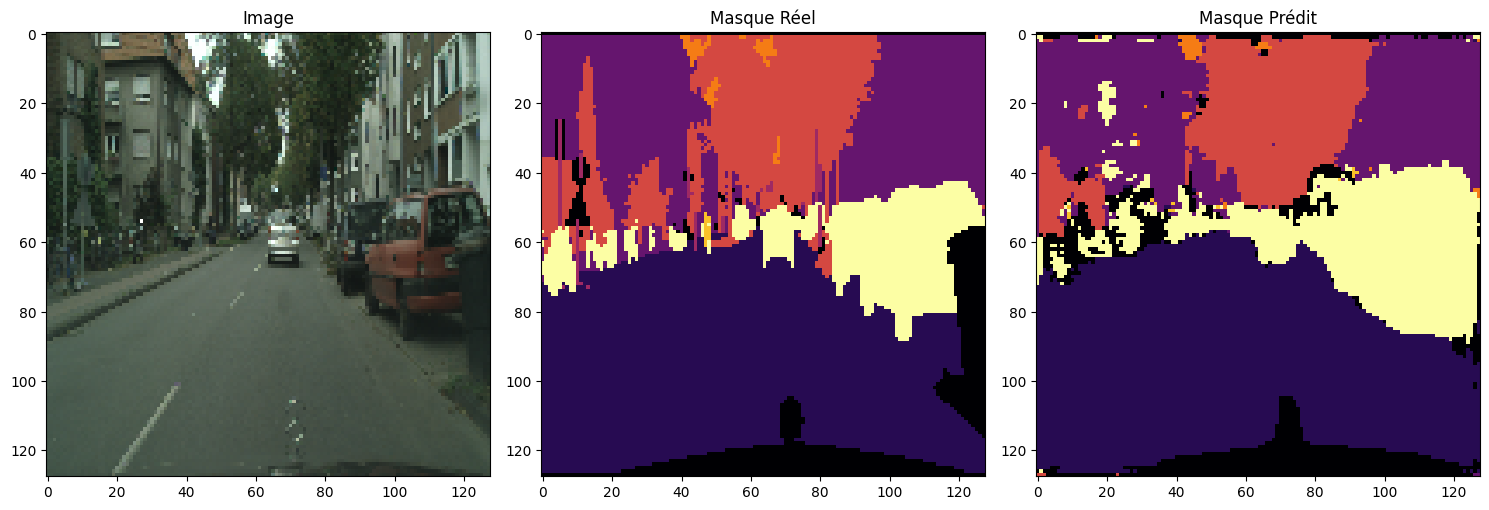

186/186 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - iou_with_conversion: 0.1320 - loss: 1.4828 - val_iou_with_conversion: 0.2398 - val_loss: 0.9128 - learning_rate: 1.0000e-04
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - iou_with_conversion: 0.3351 - loss: 0.6615
Epoch 2: val_loss improved from 0.91283 to 0.62474, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


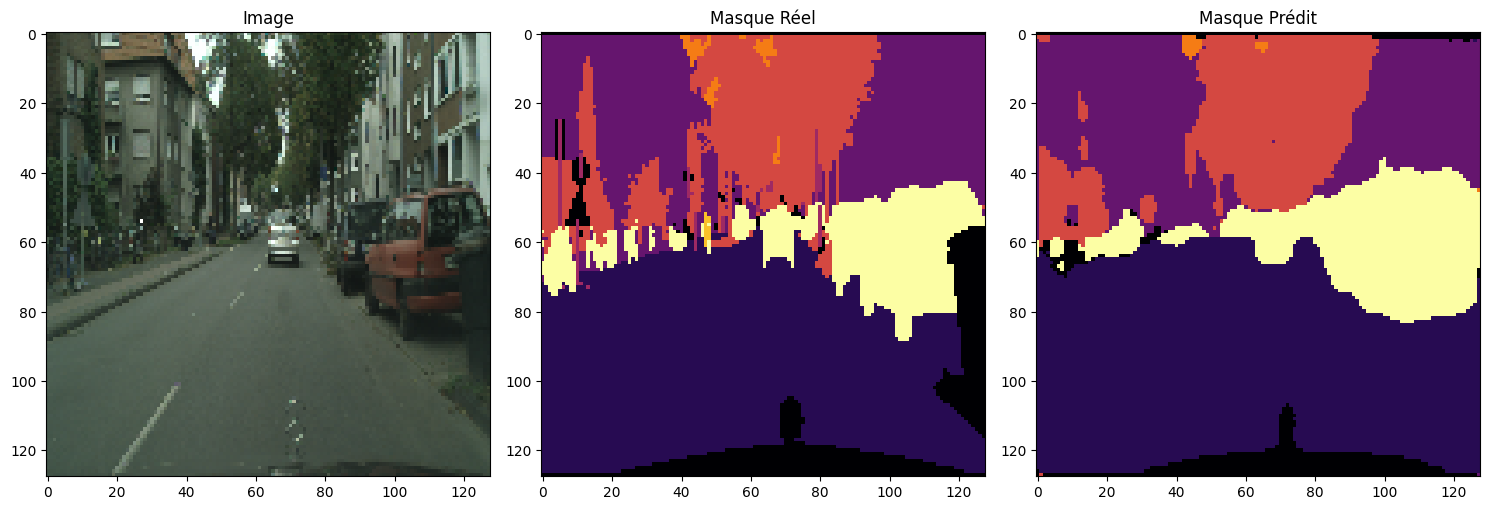

186/186 ━━━━━━━━━━━━━━━━━━━━ 177s 924ms/step - iou_with_conversion: 0.3353 - loss: 0.6613 - val_iou_with_conversion: 0.3701 - val_loss: 0.6247 - learning_rate: 1.0000e-04
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - iou_with_conversion: 0.4096 - loss: 0.5443
Epoch 3: val_loss improved from 0.62474 to 0.51598, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


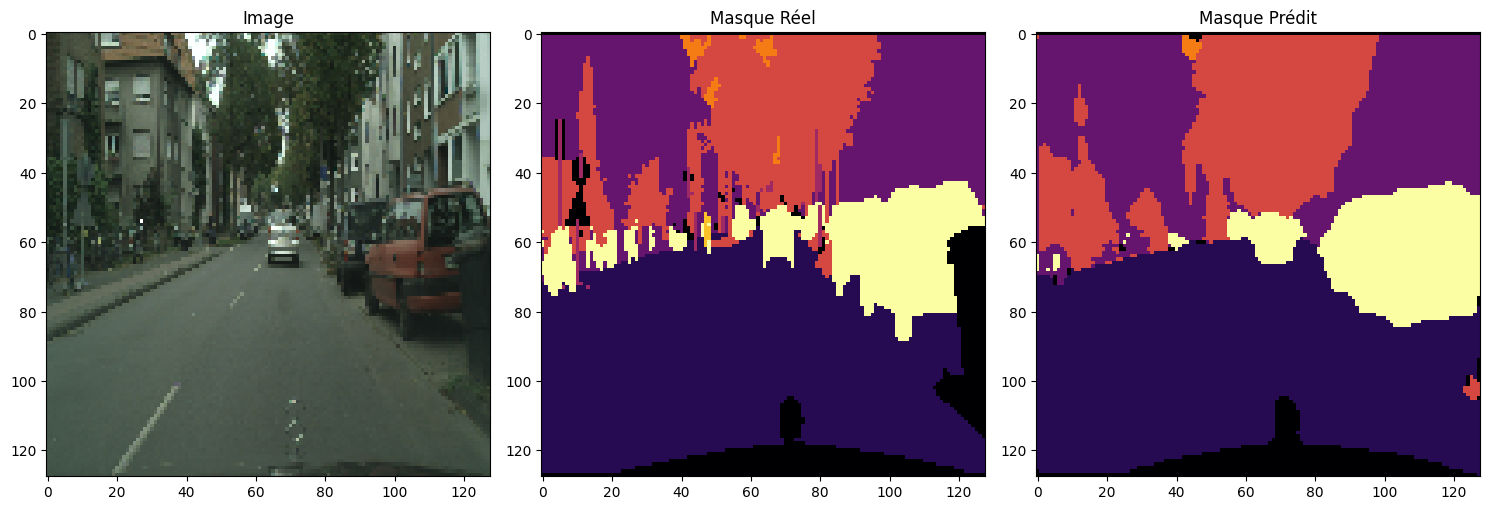

186/186 ━━━━━━━━━━━━━━━━━━━━ 181s 940ms/step - iou_with_conversion: 0.4096 - loss: 0.5442 - val_iou_with_conversion: 0.4420 - val_loss: 0.5160 - learning_rate: 1.0000e-04
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - iou_with_conversion: 0.4479 - loss: 0.4924
Epoch 4: val_loss improved from 0.51598 to 0.49328, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


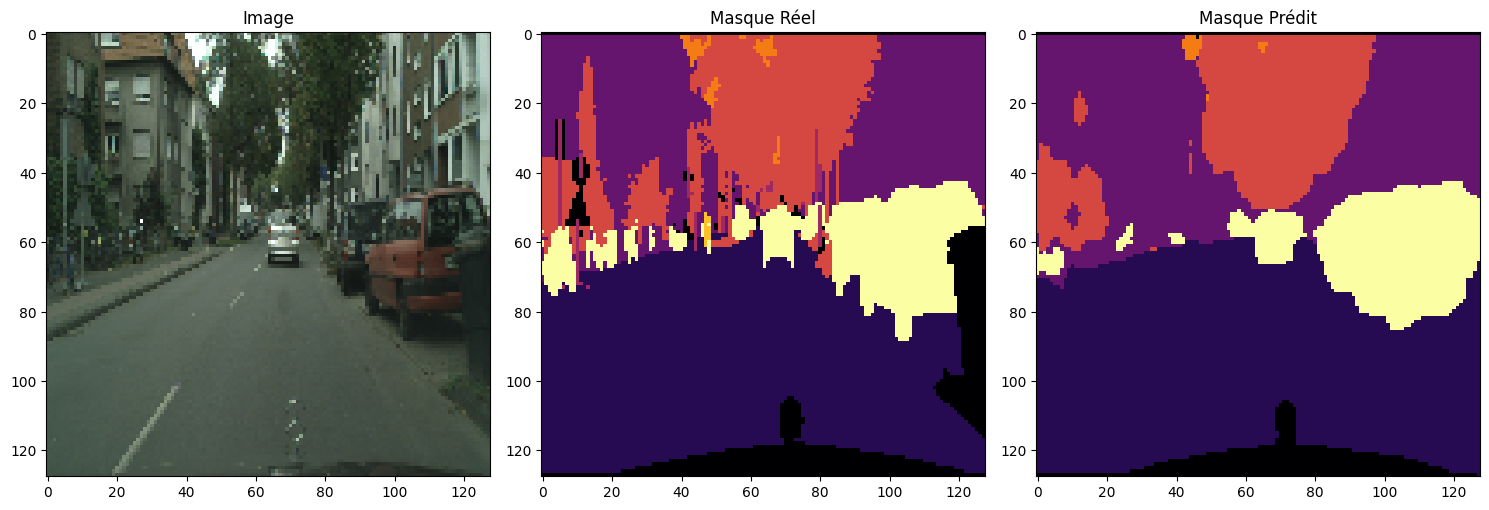

186/186 ━━━━━━━━━━━━━━━━━━━━ 179s 934ms/step - iou_with_conversion: 0.4480 - loss: 0.4924 - val_iou_with_conversion: 0.4662 - val_loss: 0.4933 - learning_rate: 1.0000e-04
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - iou_with_conversion: 0.4678 - loss: 0.4604
Epoch 5: val_loss improved from 0.49328 to 0.46511, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


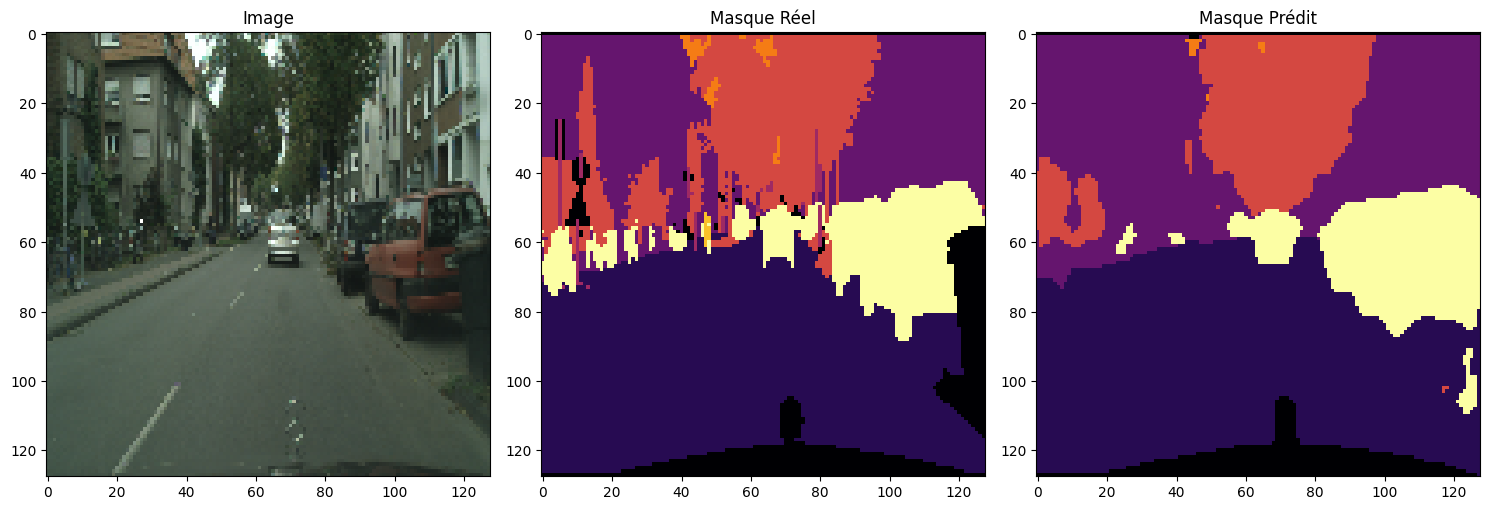

186/186 ━━━━━━━━━━━━━━━━━━━━ 180s 936ms/step - iou_with_conversion: 0.4678 - loss: 0.4604 - val_iou_with_conversion: 0.4760 - val_loss: 0.4651 - learning_rate: 1.0000e-04
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - iou_with_conversion: 0.4853 - loss: 0.4342
Epoch 6: val_loss improved from 0.46511 to 0.43866, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


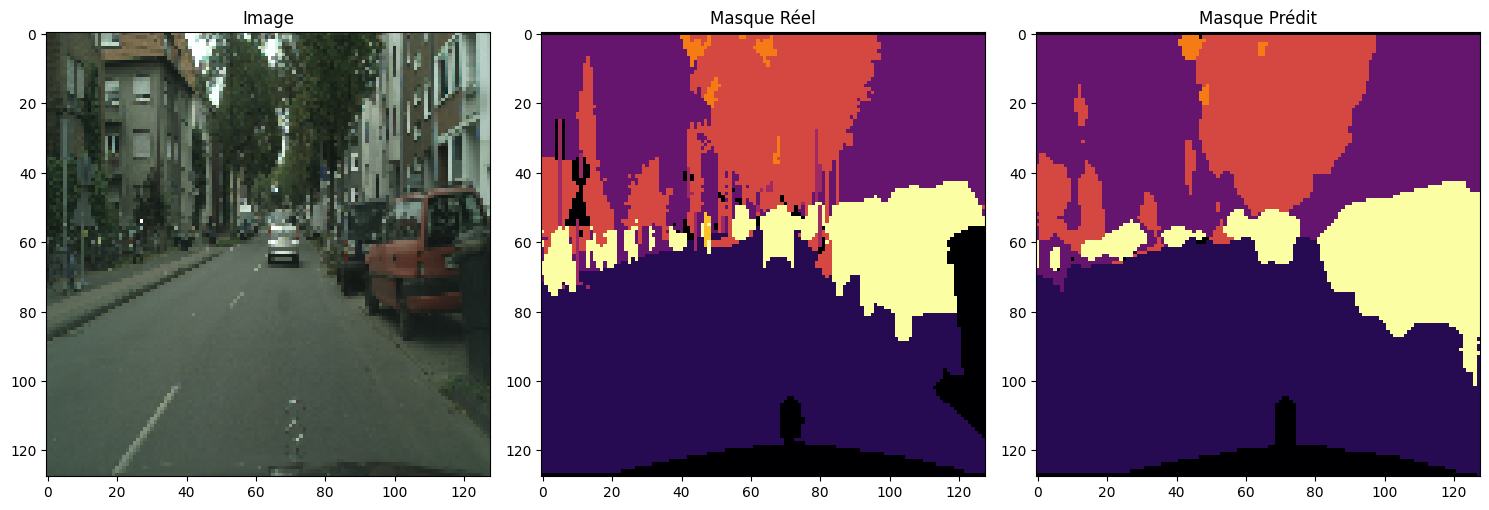

186/186 ━━━━━━━━━━━━━━━━━━━━ 183s 953ms/step - iou_with_conversion: 0.4853 - loss: 0.4342 - val_iou_with_conversion: 0.4857 - val_loss: 0.4387 - learning_rate: 1.0000e-04
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - iou_with_conversion: 0.4948 - loss: 0.4231
Epoch 7: val_loss improved from 0.43866 to 0.42925, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


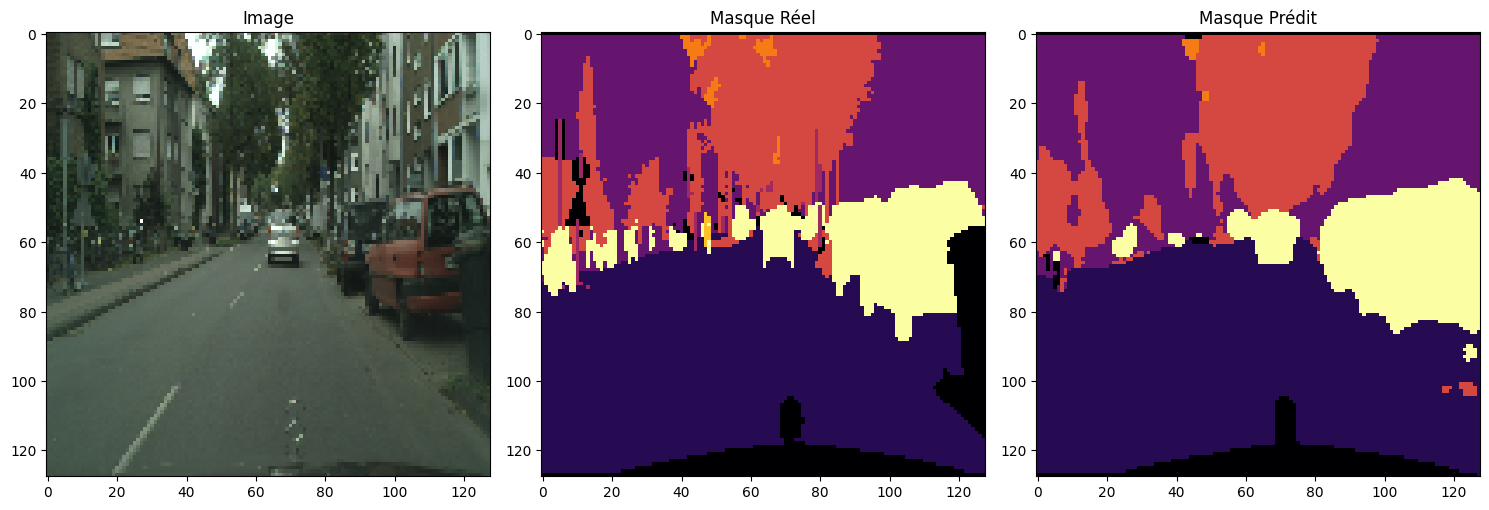

186/186 ━━━━━━━━━━━━━━━━━━━━ 181s 939ms/step - iou_with_conversion: 0.4948 - loss: 0.4231 - val_iou_with_conversion: 0.5048 - val_loss: 0.4292 - learning_rate: 1.0000e-04
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - iou_with_conversion: 0.5088 - loss: 0.4026
Epoch 8: val_loss did not improve from 0.42925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


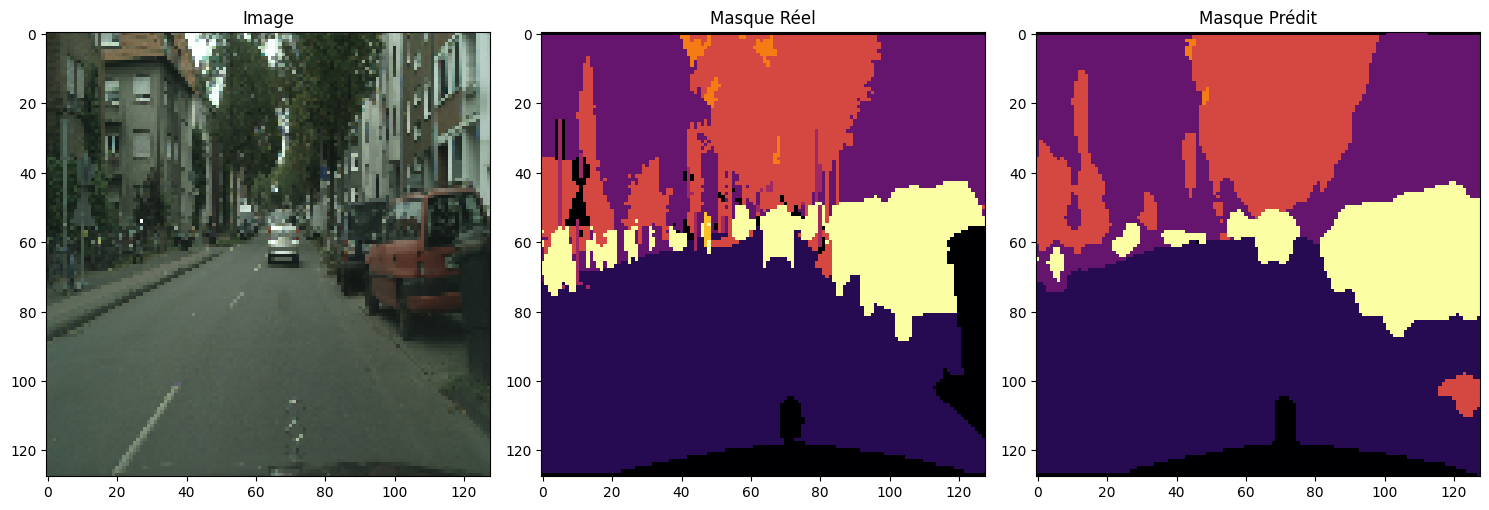

186/186 ━━━━━━━━━━━━━━━━━━━━ 176s 915ms/step - iou_with_conversion: 0.5088 - loss: 0.4025 - val_iou_with_conversion: 0.5118 - val_loss: 0.4305 - learning_rate: 1.0000e-04
Epoch 9/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - iou_with_conversion: 0.5189 - loss: 0.3891
Epoch 9: val_loss improved from 0.42925 to 0.41069, saving model to ./models/best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


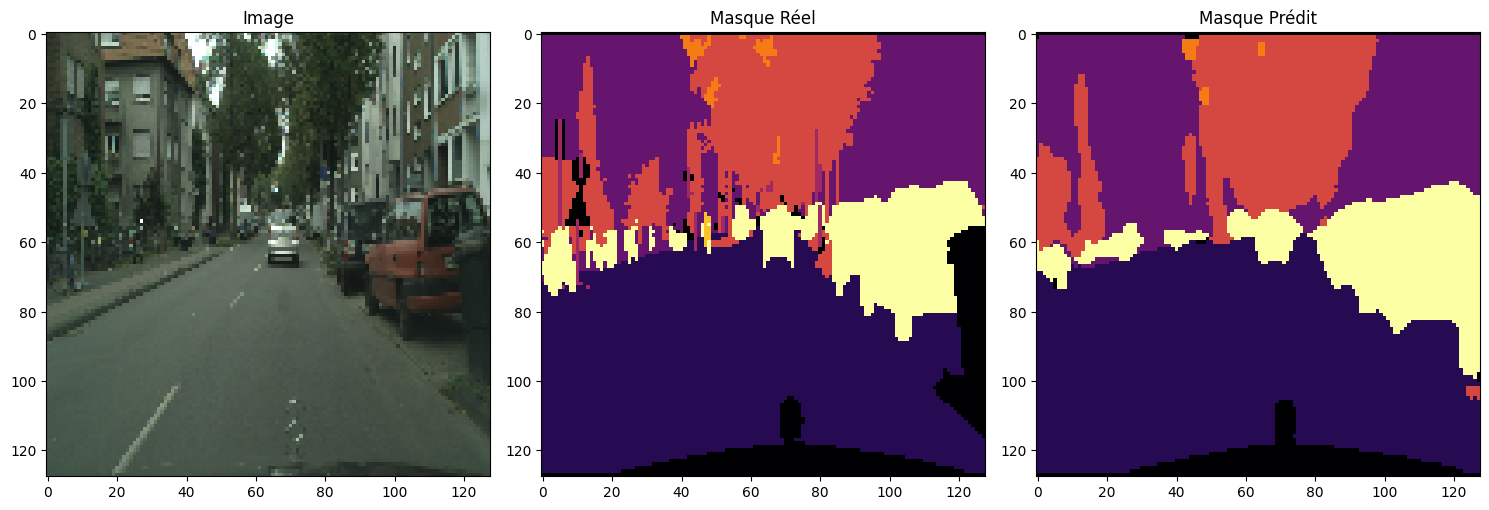

186/186 ━━━━━━━━━━━━━━━━━━━━ 178s 925ms/step - iou_with_conversion: 0.5189 - loss: 0.3891 - val_iou_with_conversion: 0.5238 - val_loss: 0.4107 - learning_rate: 1.0000e-04
Epoch 10/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - iou_with_conversion: 0.5263 - loss: 0.3818
Epoch 10: val_loss did not improve from 0.41069
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


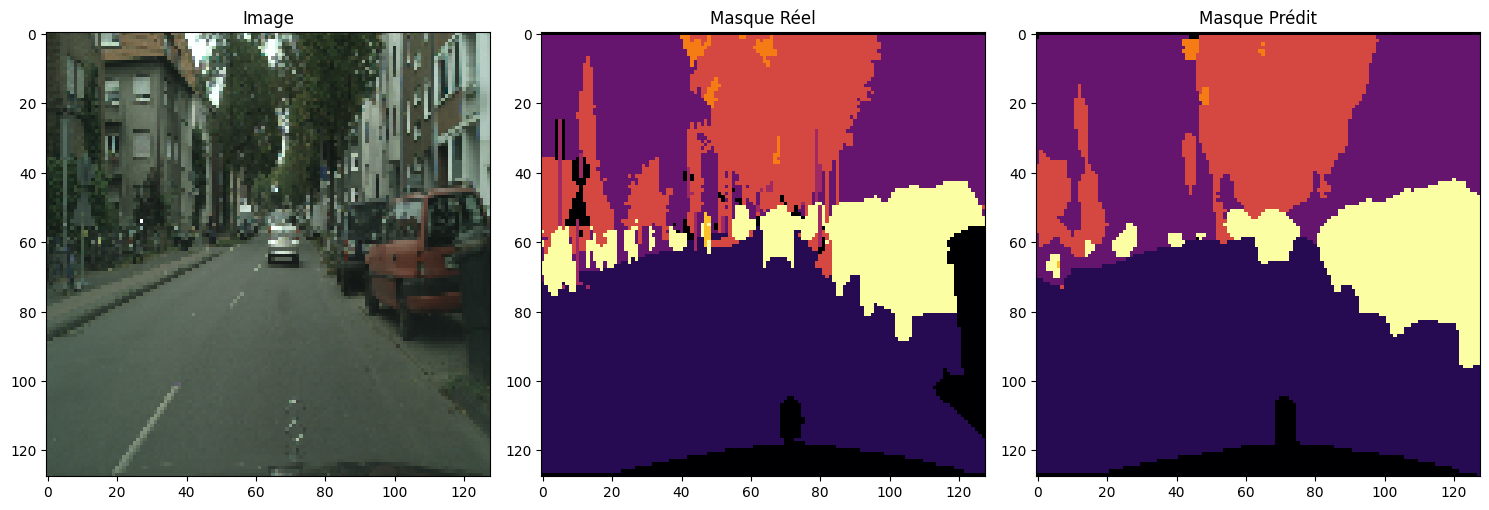

186/186 ━━━━━━━━━━━━━━━━━━━━ 175s 911ms/step - iou_with_conversion: 0.5263 - loss: 0.3818 - val_iou_with_conversion: 0.5203 - val_loss: 0.4189 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.

Entraînement terminé.
Les meilleurs poids ont été restaurés.


In [15]:
# Entraînement
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# Résumé final
print("\nEntraînement terminé.")
print("Les meilleurs poids ont été restaurés.")

In [21]:
def plot_loss_iou(history):
    # Récupération des données d'historique
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    iou = history.history['iou_with_conversion']
    val_iou = history.history['val_iou_with_conversion']
    _epochs = list(range(1, len(loss) + 1))

    # Tracé des courbes de perte
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(_epochs, loss, 'y', label='Perte Training')
    plt.plot(_epochs, val_loss, 'r', label='Perte Validation')
    plt.title('Perte Training et Validation')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()
    plt.grid(True)
    
    # Tracé des courbes de l'IoU
    plt.subplot(1, 2, 2)
    plt.plot(_epochs, iou, 'y', label='IoU Training')
    plt.plot(_epochs, val_iou, 'r', label='IoU Validation')
    plt.title('IoU Training et Validation')
    plt.xlabel('Époques')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


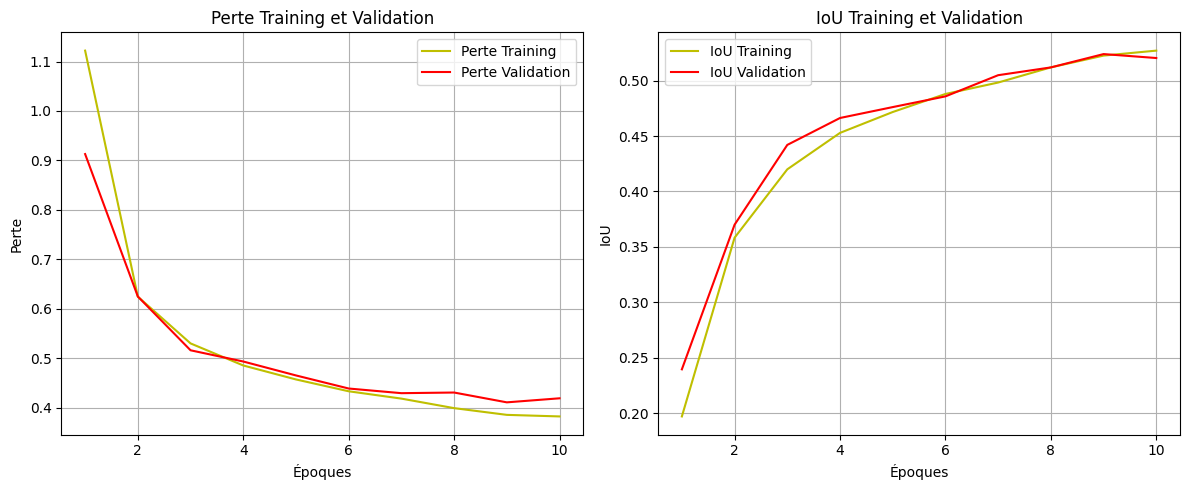

In [22]:
plot_loss_iou(history)  

## Résultats sur test

In [18]:
from tensorflow.keras.models import load_model

# Charger le meilleur modèle
model = load_model("./models/best_model.keras", custom_objects={'IOU_with_conversion': IOU_with_conversion})


In [20]:
predictions = model.predict(test_gen, verbose=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step


In [22]:
predictions.shape

(701, 128, 128, 8)

In [21]:
test_loss, test_iou_with_conversion = model.evaluate(test_gen)
print(f"Test Loss: {test_loss}")
print(f"Test IoU: {test_iou_with_conversion}")


44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - iou_with_conversion: 0.3267 - loss: 0.9813
Test Loss: 0.9095773100852966
Test IoU: 0.33030200004577637


In [76]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
import cv2  # Utilisé pour charger les images
import matplotlib.pyplot as plt  # Pour visualiser la carte de chaleur

def calculate_iou_per_class(predictions, test_label_ids_img_paths, class_names):
    """
    Calcule l'IoU pour chaque classe sur un ensemble de prédictions et de labels.

    Arguments:
    - predictions: np.array de dimension (num_samples, height, width, num_classes)
    - test_label_ids_img_paths: Tableau de chemins vers les fichiers d'images des labels (en indices de classe)
    - class_names: liste des noms des classes, taille num_classes

    Retourne:
    - dict contenant IoU pour chaque classe
    """
    # Charger les labels depuis les chemins et préparer les dimensions
    num_samples, height, width, num_classes = predictions.shape
    labels = np.zeros((num_samples, height, width, num_classes), dtype=np.float32)

    for i, label_path in enumerate(test_label_ids_img_paths):
        # Charger l'image des labels en niveaux de gris
        label_image = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        if label_image is None:
            raise FileNotFoundError(f"Impossible de charger l'image : {label_path}")

        # Redimensionner l'image pour correspondre aux dimensions des prédictions
        resized_label_image = cv2.resize(label_image, (width, height), interpolation=cv2.INTER_NEAREST)

        # One-hot encoding
        labels[i] = to_categorical(resized_label_image, num_classes=num_classes)

    # Conversion des prédictions one-hot encodées en indices de classe
    pred_indices = np.argmax(predictions, axis=-1)
    label_indices = np.argmax(labels, axis=-1)

    # Initialisation
    iou_dict = {class_name: 0.0 for class_name in class_names}
    iou_counts = {class_name: 0 for class_name in class_names}

    # Calcul des IoU pour chaque classe
    for true_class in range(num_classes):
        true_class_name = class_names[true_class]
        true_mask = (label_indices == true_class)
        intersection = 0
        union = 0

        for pred_class in range(num_classes):
            pred_mask = (pred_indices == pred_class)
            intersection += np.logical_and(true_mask, pred_mask).sum()
            union += np.logical_or(true_mask, pred_mask).sum()

        # Calcul de l'IoU pour la classe actuelle
        if union > 0:
            iou_dict[true_class_name] = intersection / union

    return iou_dict

def calculate_confusion_matrix(predictions, test_label_ids_img_paths, class_names):
    """
    Calcule une matrice de confusion multiclasse.

    Arguments:
    - predictions: np.array de dimension (num_samples, height, width, num_classes)
    - test_label_ids_img_paths: Tableau de chemins vers les fichiers d'images des labels (en indices de classe)
    - class_names: liste des noms des classes, taille num_classes

    Retourne:
    - np.array de dimension (num_classes, num_classes) représentant la matrice de confusion
    """
    # Charger les labels depuis les chemins et préparer les dimensions
    num_samples, height, width, num_classes = predictions.shape
    labels = np.zeros((num_samples, height, width), dtype=np.int32)

    for i, label_path in enumerate(test_label_ids_img_paths):
        # Charger l'image des labels en niveaux de gris
        label_image = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        if label_image is None:
            raise FileNotFoundError(f"Impossible de charger l'image : {label_path}")

        # Redimensionner l'image pour correspondre aux dimensions des prédictions
        resized_label_image = cv2.resize(label_image, (width, height), interpolation=cv2.INTER_NEAREST)

        # Stocker les indices de classe
        labels[i] = resized_label_image

    # Conversion des prédictions one-hot encodées en indices de classe
    pred_indices = np.argmax(predictions, axis=-1)

    # Initialisation de la matrice de confusion
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Remplissage de la matrice de confusion
    for true_class in range(num_classes):
        true_mask = (labels == true_class)

        for pred_class in range(num_classes):
            pred_mask = (pred_indices == pred_class)
            confusion_matrix[true_class, pred_class] += np.logical_and(true_mask, pred_mask).sum()

    return confusion_matrix

def plot_confusion_heatmap(confusion_matrix, class_names, cmap="magma_r"):
    """
    Affiche une carte de chaleur pour la matrice de confusion.

    Arguments:
    - confusion_matrix: matrice de confusion (num_classes, num_classes)
    - class_names: liste des noms des classes
    - cmap: colormap pour la carte de chaleur
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix, interpolation="nearest", cmap=cmap)
    plt.colorbar(label="Nombre de pixels")
    plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités terrain")
    plt.title("Matrice de confusion multiclasse")
    plt.tight_layout()
    plt.show()

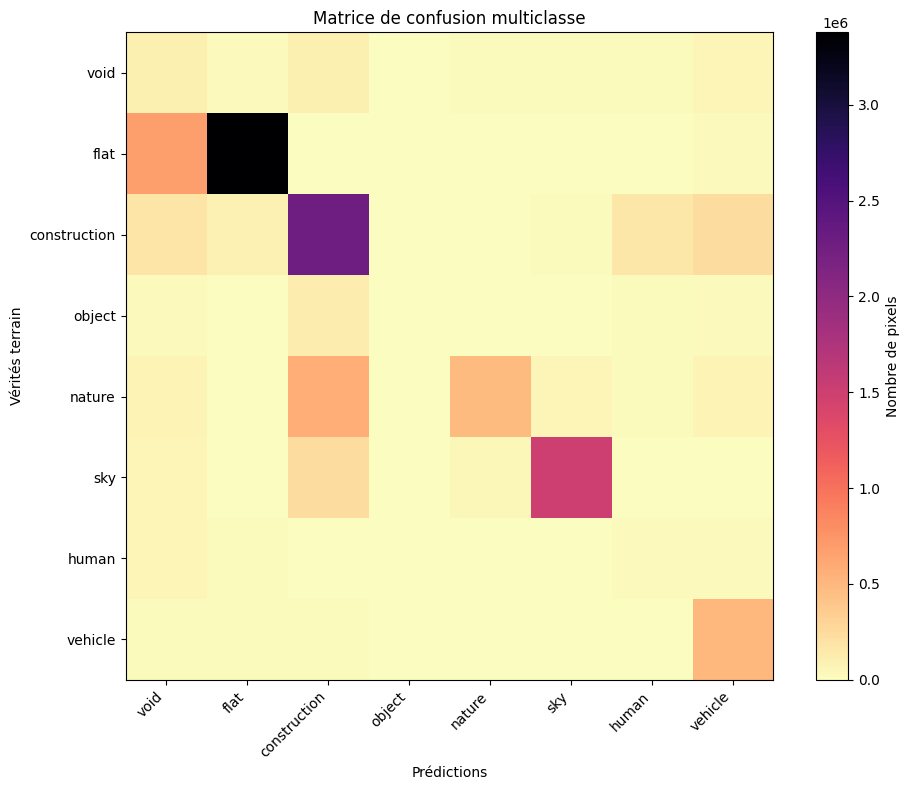

In [77]:
# Exemple d'utilisation
# predictions = np.random.rand(701, 128, 128, 8)
# test_label_ids_img_paths = np.array([
#     '/tf/CamVid/CamVidGray8/0001TP_006690_L.png',
#     '/tf/CamVid/CamVidGray8/0001TP_006720_L.png'
# ])
# class_names = ['void', 'flat', 'construction', 'object', 'nature', 'sky', 'human', 'vehicle']

confusion_matrix = calculate_confusion_matrix(predictions, test_label_ids_img_paths, class_names)
plot_confusion_heatmap(confusion_matrix, class_names)

In [54]:
iou_scores = calculate_iou_per_class(predictions, test_label_ids_img_paths, class_names)
for class_name, iou in iou_scores.items():
    print(f"Classe {class_name}: IoU = {iou:.4f}")

Classe void: IoU = 0.0246
Classe flat: IoU = 0.1019
Classe construction: IoU = 0.0919
Classe object: IoU = 0.0181
Classe nature: IoU = 0.0629
Classe sky: IoU = 0.0757
Classe human: IoU = 0.0114
Classe vehicle: IoU = 0.0373
